# Homework 2: DDPM

## Section A

In this section, we will implement DDPM (**Denoising Diffusion Probabilistic Models**) on a simple 1D Mixture of Gaussians Model.

Note that GPUs will not help in any part except the final section with the generation of images (everything else runs in less than a second), so it is recommended to run this part of the homework on a local CPU.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

A Gaussian Mixture Model is a distribution that is the combination of several Gaussian distributions, such as the following:

$$
X | Y \sim \mathcal{N}(\mu_1, \sigma_1 I)Y + \mathcal{N}(\mu_2, \sigma_2 I)(1 - Y)
$$

where $Y \sim \text{Ber}(p)$. In our case, $X \in \mathbb{R}^1$.

In [ ]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0], bins=50)
plt.show()


In [ ]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02
ALPHA = 1 - BETA
ALPHA_BAR = [ALPHA ** i for i in range(TIME_STEPS+1)]

Pay attention - beta is constant, hence $x_{t+1}$ is sampled from $q_t = \N(\sqrt{1-\beta}x_t, \sqrt{\beta})$

Implement the following functions to perform ddpm and restore the original given distribution. You can add any other functions required.

In [ ]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    ''''
    perform diffusion following equation 2
    returns a list of q(x(t)) and x(t)
    starting from t=0 (i.e., the dataset)
    
    :param data: torch.Size([1000, 1])
    :return samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :return distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    '''


    distributions, samples = [None], [data]
    xt = data # = data_distribution.sample(torch.Size([1000, 1]))
        
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####     

    return distributions, samples 

Sample and visualize realizations of the forward/diffusion process over time, using samples from do_diffusion(dataset)

In [ ]:
_, samples = do_diffusion(dataset)

#### ADD YOUR CODE HERE ####

#### DONE WITH SOLUTION #### 

# Training
We first use the loss in Equation 3 in the paper without any of the optimizations presented later, which a play significant role for complex, real-world distributions.

Diffusion models are trained by first corrupting the training examples, then trying to reconstruct the cleaner examples from the noisy examples at each step of the corruption process. The loss is an upper bound on the negative log likelihood:

$L := \mathbb{E}_q\left[
-\log p(x_T)
-\sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} 
\right]$

Where the generative model, also called reverse process, has form:

$p_\theta(x_{t-1}|x_t):=\mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta(x_t, t))$

Note that we are training two neural networks, $\mu_\theta$ and $\Sigma_\theta$, which take as input a noisy sample $x_t$ and the step $t$, and try to predict the parameters of the distribution of the sample $x_{t-1}$ to which noise was added. Intuitively, we are training these networks to maximize the predicted probability of observing the uncorrputed example $x_{t-1}$ based on $x_t$ , i.e., the term $p_\theta(x_{t-1}\vert x_t)$ in the loss, for each diffusion step. Remember that $x_t$ was generated earlier from $x_{t-1}$ by adding noise; the networks have to learn to undo the noise. The other terms in the loss involving $q(x_t\vert x_{t-1})$ are not necessary to learn a good generative model, since they are constant, but are useful as a “frame of reference” to make a “perfect” generative model achieve a loss of 0.

You should implement the loss in the function below. This function requires the entire diffusion trajectory for the training samples, as well as the two neural networks that define the inverse process:

In [ ]:
def compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model):
    """
    Compute the loss in equation 3
    forward = q , reverse = p

    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :return: averaged loss over total TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION #### 


We also implement and use the loss in Equation 12 in the paper with the suggested optimizations presented.

In [ ]:
def compute_loss_equation12(forward_samples, noise_model):
    """
    Compute the loss in equation 12
    forward = q , reverse = p
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param noise_model: torch.nn.Module
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION #### 


In [ ]:
def compute_loss(equation, forward_distributions, forward_samples, mean_model, var_model, noise_model):
    """
    Compute the loss according to the given equation (just a wrapper)
    :param equation: int
    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION #### 

Now define three very simple neural networks to predict the mean/variance/noise, and an optimizer.

These networks take two inputs: the noisy sample $x_t$ and the normalized time-step t. The time-step is added as an additional column feature, and, since the input is also one-dimensional, the total input size is two.

When you are happy with your simple model architecure, show the training curve for both equations.

In [ ]:
#### ADD YOUR CODE HERE ####

#### DONE WITH SOLUTION #### 

In [ ]:
def train_loop(dataset, mean_model, var_model, noise_model, optim):    
    """
    Train the model
    :param dataset: torch.Size([1000, 1])
    :param mean_model: Optinal(torch.nn.Module) = None
    :param var_model: Optinal(torch.nn.Module) = None
    :param noise_model: Optinal(torch.nn.Module) = None
    :param optim: torch.optim
    :return: list of losses by epoch
    """
    loss_history = []
    bar = tqdm(range(300))
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####    

    return loss_history    

loss_history = train_loop(dataset, mean_model, var_model, noise_model, optim)
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()


In [ ]:
def save_model(model, filepath):
    """
    Save the PyTorch model to a file.
    
    Args:
        model (torch.nn.Module): The PyTorch model to save.
        filepath (str): The path to save the model file.
    """
    torch.save(model.state_dict(), filepath)
    print("Model saved successfully.")

def load_model(model_class, filepath):
    """
    Load a PyTorch model from a file.
    
    Args:
        model_class (torch.nn.Module): The class of the PyTorch model to load.
        filepath (str): The path to the saved model file.
        
    Returns:
        model (torch.nn.Module): The loaded PyTorch model.
    """
    model_type = filepath.split("/")[-1].split("_")[0]
    #### ADD YOUR CODE HERE ####
    if model_type == "mean":
        model = torch.nn.Sequential(
            
        )
    elif model_type == "var":
        model = torch.nn.Sequential(
            
        )
    elif model_type == "noise":
        model = torch.nn.Sequential(
            
        )
    else:
        raise ValueError("Invalid model type.")        

    #### DONE WITH SOLUTION ####  
      
    model.load_state_dict(torch.load(filepath), strict=False)
    model.eval()
    print("Model loaded successfully.")
    return model

#save_model(mean_model, "models/mean_model.pth")
#save_model(var_model, "models/var_model.pth")
#save_model(noise_model, "models/noise_model.pth")


#mean_model = load_model(torch.nn.Sequential, "models/mean_model.pth")
#var_model = load_model(torch.nn.Sequential, "models/var_model.pth")
#noise_model = load_model(torch.nn.Sequential, "models/noise_model.pth")

# Sampling
Implement the original paper's sampling procedure, for both equations 3,12

In [ ]:
def sample_reverse_equation3(mean_model, var_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 3
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    
    #### DONE WITH SOLUTION ####
    return sample_history

def sample_reverse_equation12(noise_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 12
    :param noise_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####    
        
    return sample_history

In [ ]:
def sample_reverse(equation, mean_model, var_model, noise_model, count, steps=1000):
    """
    Sample from the reverse process using the given equation, it's a wrapper
    :param equation: int
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####

Show us your reverse sampling, x axis is time, y axis it the sampled process realization value.

Afterwards, compare the original distribution, with each of the estimated distributions, seperatly. 

Add at the end of this section, where do you think the diffrence between the FIDs and the charts is coming from.

In [ ]:
#### ADD YOUR CODE HERE ####


#### DONE WITH SOLUTION ####

In [ ]:
#### ADD YOUR CODE HERE ####

#### DONE WITH SOLUTION ####

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000):
    """
    Calculate the Frechet Inception Distance (FID) between the target distribution and the generated samples, uzilizing scipy.linalg.sqrtm
    :param data_distribution: torch.distributions.mixture_same_family.MixtureSameFamily
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param noise_model: torch.nn.Module
    :param count: int
    """
    
    original_samples = data_distribution.sample(torch.Size([10000, 1]))  # from your target distribution
    generated_samples_3 =  torch.stack(sample_reverse(3, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model
    generated_samples_12 =  torch.stack(sample_reverse(12, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model

    #### ADD YOUR CODE HERE ####

        
    #### DONE WITH SOLUTION ####    


compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000)

In [ ]:
## ADD YOUR HYPOTHESIS REGARDING THE DIFFRENCE HERE - Change this cell into Markdown ##

#### DONE WITH SOLUTION ####

## Section B

In this section, we will implement DDPM on multidimentional, unknown distribution.
Same as in previous section, will be based on the original DDPM paper by ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))

In [ ]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

### Network helpers

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """
    simply adds the input to the output of a particular function
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$.


In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings, as described in the paper
    """

    def __init__(self, dim):
        """
        :param dim: int, the dimension of the embeddings
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: torch Tenseor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block.

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. 


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization.

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + a downsample operation
* at the middle of the network, again ResNet blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + an upsample operation
* finally, a ResNet block followed by a convolutional layer is applied.

Watch carefully every element of this architecture, what it is doing, which input shape and output shape it has.

In [ ]:
class Unet(nn.Module):
    """
    Unet architecture for diffusion models
    the network takes a batch of noisy images of shape (batch_size, num_channels, height, width) 
    and a batch of noise levels of shape (batch_size, 1) as input
    and returns a tensor of shape (batch_size, num_channels, height, width)
    """
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=1
    ):
        super().__init__()

        #### ADD YOUR CODE HERE ####


        #### DONE WITH SOLUTION ####

    def forward(self, x, time):
        """
        :param x: torch Tensor of shape (batch_size, channels, height, width)
        :param time: torch Tensor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, channels, height, width)
        """

        #### ADD YOUR CODE HERE ####


        #### DONE WITH SOLUTION ####

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$, according to a **variance schedule**.

Implement both.

In [ ]:
def linear_beta_schedule(timesteps):
    """
    set the forward process variances to constants
    increasing linearly from beta_1 = 0.0001 to beta_T = 0.02.
    :param timesteps: int
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####
    return torch.linspace(beta_start, beta_end, timesteps)
    

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672))
    :param timesteps: int
    :param s: float
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####
    return torch.clip(betas, 0.0001, 0.9999)
    

To start with, let's use the linear schedule for $T=200$ time steps.

Define the variables $\beta_t$, $\alpha_t$ for each $t$, the cumulative product of the variances $\bar{\alpha}_t$, and every other variable that is helpful.

Each should be a 1-dimensional tensors, storing values from $t$ to $T$. Later use the extact function to extract the appropriate $t$ index for a batch of indices.


In [ ]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)


# define alphas
#### ADD YOUR CODE HERE ####
alphas = 
alphas_cumprod = 
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = 
#### DONE WITH SOLUTION ####

# calculations for diffusion q(x_t | x_{t-1}) and others
#### ADD YOUR CODE HERE ####
sqrt_alphas_cumprod = 
sqrt_one_minus_alphas_cumprod = 
#### DONE WITH SOLUTION ####

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    # extracts the appropriate $t$ index for a batch of indices
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

From the DPPM paper:

> We assume that image data consists of integers in $\{0, 1, ... , 255\}$ scaled linearly to $[−1, 1]$. This
ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior $p(\mathbf{x}_T )$.

In [ ]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np
from PIL import Image
import requests

image_size = 32
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

url = 'some-url-to-an-image'
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
x_start.shape
reverse_transform(x_start.squeeze())

### Forward/ Diffusion process ###

In [ ]:
# forward diffusion q(x_t | x_0)
def q_sample(x_start, t, noise=None):
    """
    q_sample function for diffusion process
    :param x_start: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param noise: Optional(torch.Tensor) = None
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####

Test your result on a particular time step:

In [ ]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

#### ADD YOUR CODE HERE ####

#### DONE WITH SOLUTION ####

Now visualize this for various time steps:

In [ ]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

#### ADD YOUR CODE HERE ####
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Plot a list of images in a grid.
    :param imgs: list of images to plot
    :param with_orig: bool, whether to include the original image
    :param row_title: list of titles for each row
    :param imshow_kwargs: additional arguments for imshow
    """

#### DONE WITH SOLUTION ####

plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])


Define the loss function given the model. Use the U-Net defined above.


In [ ]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Define a PyTorch Dataset + DataLoader

The dataset is Fashion-MNIST, to easily load the Fashion MNIST dataset from the [hub](https://huggingface.co/datasets/fashion_mnist). 
The images suppose to be 28x28 grayscale images, scaled linearly to $[-1, 1]$.

Implement a PyTorch Dataset class that loads the images and applies wanted transformations on-the-fly, and a DataLoader to load the dataset in batches.


In [ ]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

#### ADD YOUR CODE HERE ####

#### DONE WITH SOLUTION ####


## Sampling

Implement sampling algorithm 2 from the original paper: 

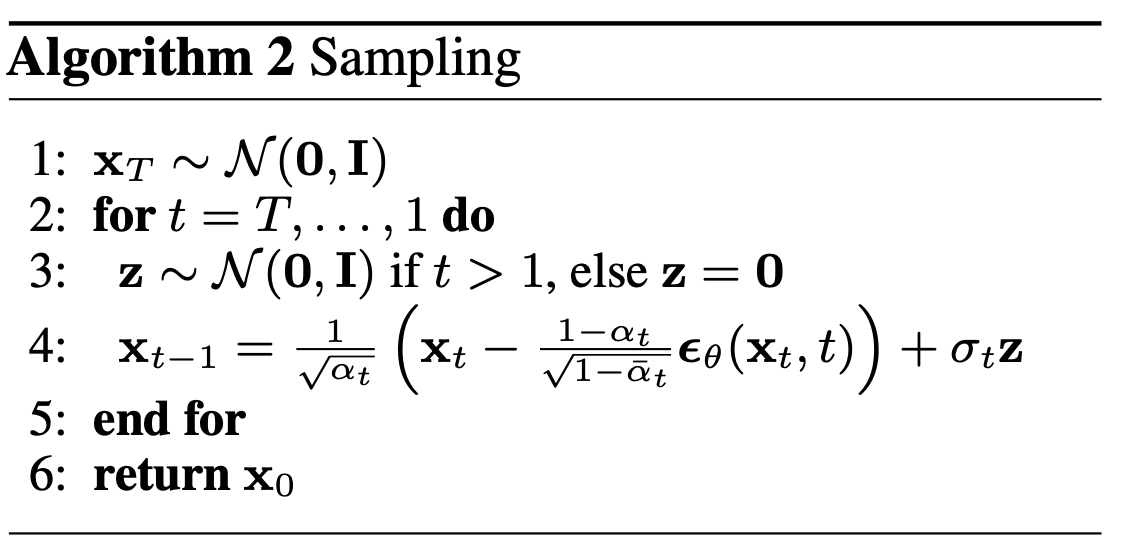

In [ ]:

@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    p_sample function for reverse process
    :param model: torch.nn.Module
    :param x: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param t_index: int
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####

    #### DONE WITH SOLUTION ####

    if t_index == 0:
        return model_mean
    else:
        #### ADD YOUR CODE HERE ####

        #### DONE WITH SOLUTION ####


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



## Train the model

Implement training algorithm 1 from the original paper: 

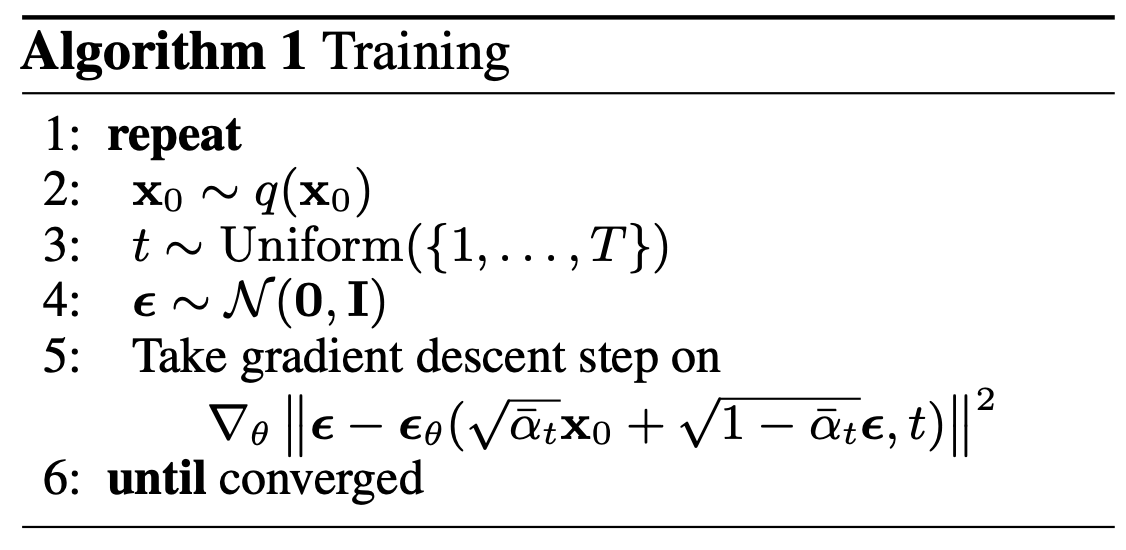

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchvision.utils import save_image
from pathlib import Path

#### ADD YOUR CODE HERE ####


#### DONE WITH SOLUTION ####        

# Sampling (inference)

To sample from the model, you can just use the sample function defined above.

### Sample at least 64 images for submission.

### The zip file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).

### Images within the zip should be .png or .jpg.


In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

#### ADD YOUR CODE HERE ####


#### DONE WITH SOLUTION ####

Run the following code to show us the denoising process 
Or Create an animation of the denoising process - for a specific sample <random_index>:

In [ ]:
import imageio
import numpy as np
from torchvision.transforms import ToPILImage
import torch
from IPython.display import Image as IPyImage, display

to_pil = ToPILImage()

random_index = 53
frames = []

for i in range(timesteps):
    img_array = samples[i][random_index]  # assumed shape [C, H, W]

    if isinstance(img_array, np.ndarray):
        img_array = (img_array + 1) / 2
        img_array = np.clip(img_array, 0, 1)
        img_tensor = torch.from_numpy(img_array)
    else:
        img_tensor = (img_array + 1) / 2
        img_tensor = img_tensor.clamp(0, 1)

    img = to_pil(img_tensor)
    frames.append(np.array(img))

gif_path = "diffusion.gif"
imageio.mimsave(gif_path, frames, duration=0.05)

display(IPyImage(filename="diffusion.gif", width=512, height=512))

### The code file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).
